In [1]:
import nequip
from nequip.ase import NequIPCalculator

calculator = NequIPCalculator.from_compiled_model(
    compile_path="./nequip_ase_6e_compiled_model.nequip.pt2",
    device="cuda",
    chemical_species_to_atom_type_map=True
)

/global/homes/s/samss/.conda/envs/nequip_env/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'Could not load this library: /global/u2/s/samss/.conda/envs/nequip_env/lib/python3.10/site-packages/torchvision/image.so'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/global/homes/s/samss/.conda/envs/nequip_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from ase.io import read

atoms = read("initial.xyz")
# atoms.calc = calculator
larger_atoms = atoms * (1, 1, 1)
larger_atoms.calc = calculator

In [3]:
import torch
from nequip.ase import NequIPCalculator
from ase.io import read
from ase import units
from ase.md.langevin import Langevin
from ase.io.trajectory import Trajectory


timestep_fs = 1.0
target_temp_K = 300
total_steps = 5000 
save_interval = 100 

dynamics = Langevin(
    larger_atoms,
    timestep=timestep_fs * units.fs,
    temperature=target_temp_K * units.kB,
    friction=0.02, 
    logfile='md.log', 
)

trajectory_output = Trajectory('md_nequip.traj', 'w', larger_atoms)
dynamics.attach(trajectory_output.write, interval=save_interval)

def print_status(a=larger_atoms):
    E_pot = a.get_potential_energy()
    temp = a.get_temperature()
    print(f"Step: {dynamics.nsteps}, T: {temp:.2f} K, E_pot: {E_pot:.2f} eV")

dynamics.attach(print_status, interval=save_interval) 

print(f"Starting MD continuation for {total_steps} steps...")
dynamics.run(total_steps)
print(f"MD simulation complete. Trajectory saved to md_nequip.traj.")

/global/homes/s/samss/.conda/envs/nequip_env/lib/python3.10/site-packages/ase/md/md.py:54: FutureWarning: Specify the temperature in K using the 'temperature_K' argument
  warnings.warn(FutureWarning(w))


Starting MD continuation for 5000 steps...
Step: 0, T: 0.00 K, E_pot: -1695.04 eV
Step: 100, T: 189.73 K, E_pot: -1700.78 eV
Step: 200, T: 237.92 K, E_pot: -1701.39 eV
Step: 300, T: 243.98 K, E_pot: -1700.09 eV
Step: 400, T: 261.02 K, E_pot: -1700.03 eV
Step: 500, T: 260.67 K, E_pot: -1698.87 eV
Step: 600, T: 267.06 K, E_pot: -1698.77 eV
Step: 700, T: 265.83 K, E_pot: -1699.19 eV
Step: 800, T: 269.69 K, E_pot: -1699.45 eV
Step: 900, T: 268.90 K, E_pot: -1699.34 eV
Step: 1000, T: 275.20 K, E_pot: -1698.82 eV
Step: 1100, T: 285.79 K, E_pot: -1698.82 eV
Step: 1200, T: 268.90 K, E_pot: -1697.81 eV
Step: 1300, T: 293.29 K, E_pot: -1698.48 eV
Step: 1400, T: 280.15 K, E_pot: -1697.48 eV
Step: 1500, T: 316.49 K, E_pot: -1698.80 eV
Step: 1600, T: 315.99 K, E_pot: -1698.47 eV
Step: 1700, T: 328.73 K, E_pot: -1698.62 eV
Step: 1800, T: 299.18 K, E_pot: -1696.97 eV
Step: 1900, T: 298.06 K, E_pot: -1696.96 eV
Step: 2000, T: 309.05 K, E_pot: -1697.25 eV
Step: 2100, T: 299.61 K, E_pot: -1696.39 eV
Ste

/tmp/ipykernel_794160/2456414976.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


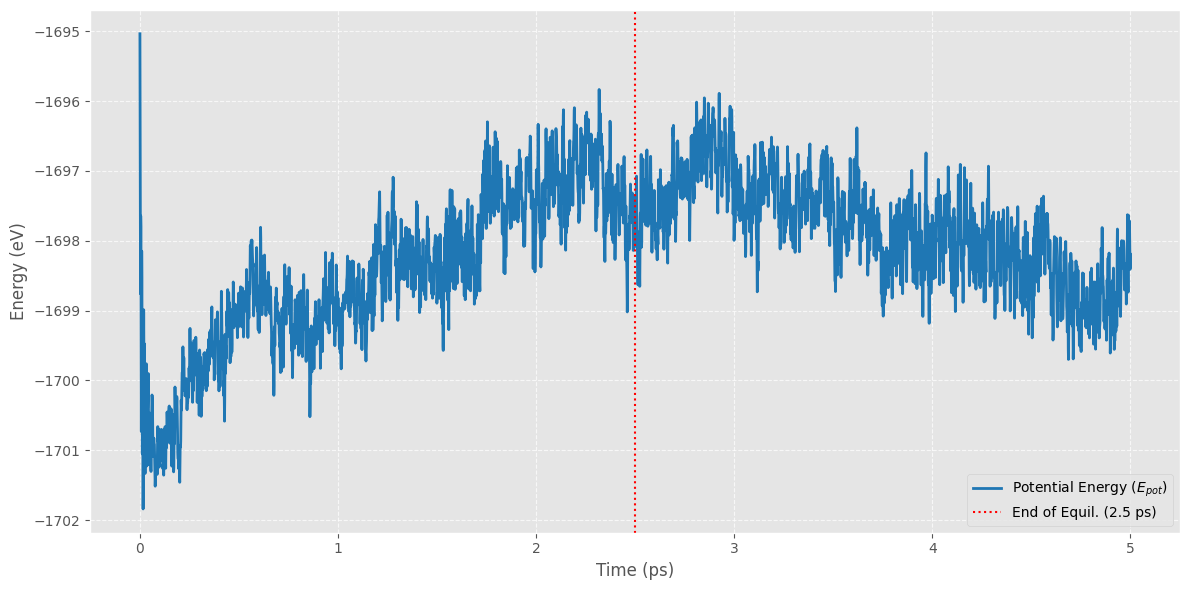

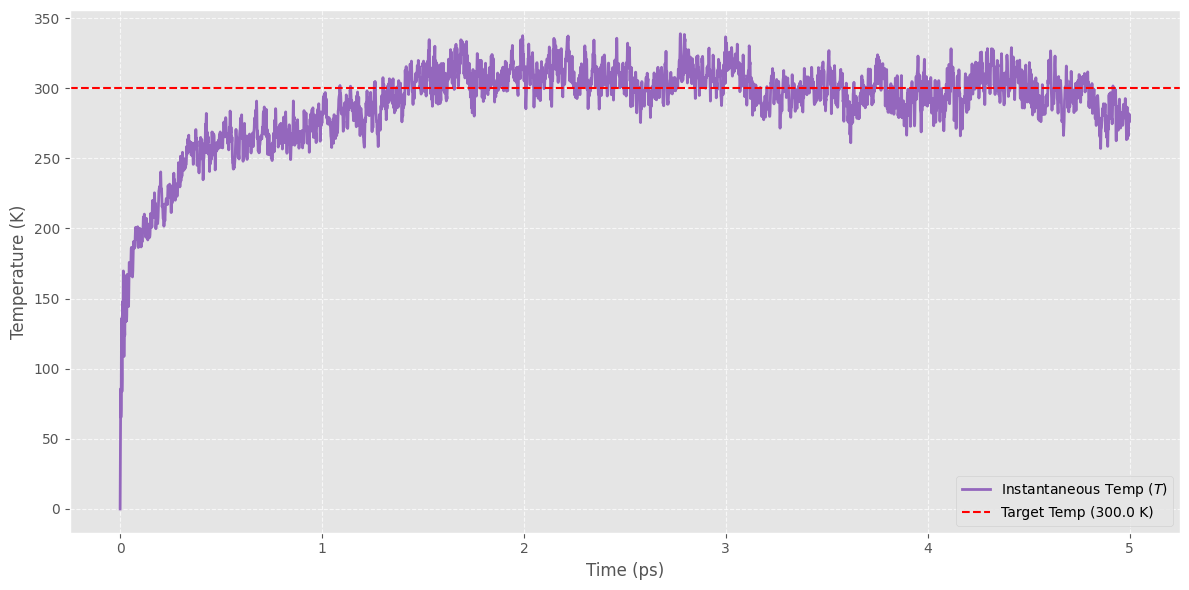

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv(
        'md.log', 
        delim_whitespace=True, 
        skiprows=1,
        names=['Time', 'Etot', 'Epot', 'Ekin', 'T']
)

df['Step'] = (df['Time'] * 1000).astype(int)


equilibration_time = 2.5 
production_df = df[df['Time'] >= equilibration_time]
target_temp = 300.0

plt.style.use('ggplot')
plt.figure(figsize=(12, 6))

plt.plot(df['Time'], df['Epot'], label='Potential Energy ($E_{pot}$)', color='#1f77b4', linewidth=2)
# plt.plot(df['Time'], df['Etot'], label='Total Energy ($E_{tot}$)', color='#2ca02c', linewidth=3, linestyle='--')

plt.axvline(x=equilibration_time, color='r', linestyle=':', label='End of Equil. (2.5 ps)')

plt.xlabel('Time (ps)')
plt.ylabel('Energy (eV)')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(df['Time'], df['T'], label='Instantaneous Temp ($T$)', color='#9467bd', linewidth=2)
plt.axhline(y=target_temp, color='r', linestyle='--', label=f'Target Temp ({target_temp} K)')

plt.xlabel('Time (ps)')
plt.ylabel('Temperature (K)')
plt.legend(loc='lower right')
# plt.ylim(0, 1.2 * target_temp) 

plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

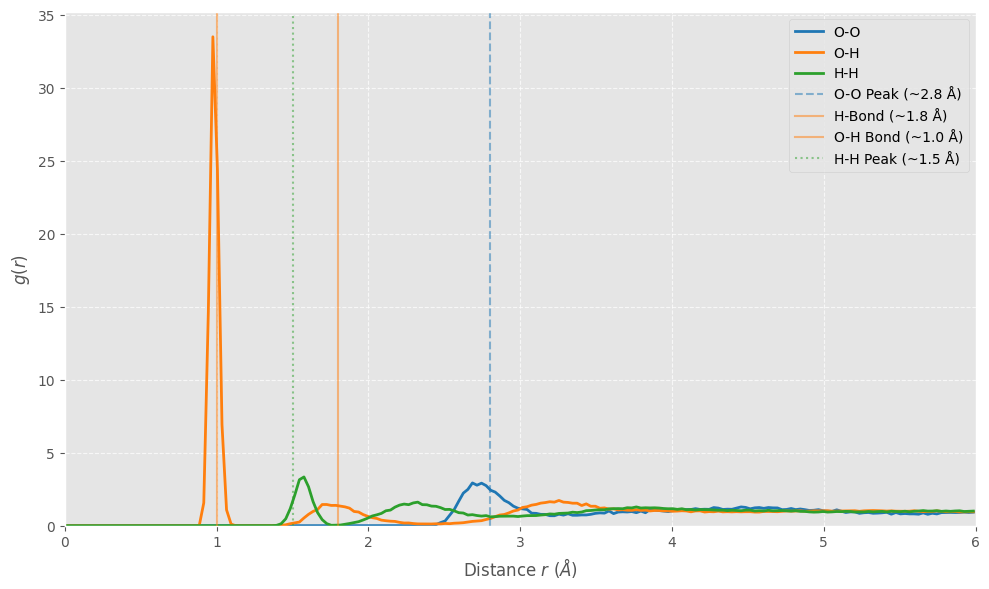

In [5]:
trajectory_file = 'md_nequip.traj'
traj_slice = '10:' 

r_max = 6.0
nbins = 200 
pairs_to_compute = [('O', 'O'), ('O', 'H'), ('H', 'H')]


def calculate_rdf_robust(frames, pairs, r_max, nbins):
    """
    Calculates RDF manually using ASE's get_all_distances.
    
    This method is preferred over ase.geometry.get_distances or Analysis classes
    because 'get_all_distances(mic=True)' robustly handles the Minimum Image 
    Convention (PBC) and returns a standard NxN matrix, avoiding shape/broadcasting 
    errors common in other utility functions.
    """
    n_frames = len(frames)

    dr = r_max / nbins
    r_coords = np.linspace(dr/2, r_max - dr/2, nbins)
    bin_edges = np.linspace(0, r_max, nbins + 1)
    
    histograms = {f"{p[0]}-{p[1]}": np.zeros(nbins) for p in pairs}

    for i, atoms in enumerate(frames):

        D_matrix = atoms.get_all_distances(mic=True)
        
        symbols = np.array(atoms.get_chemical_symbols())
        
        for (elem1, elem2) in pairs:
            label = f"{elem1}-{elem2}"
            
            mask1 = (symbols == elem1)
            mask2 = (symbols == elem2)
            
            D_sub = D_matrix[np.ix_(mask1, mask2)]
            
            if elem1 == elem2:
                dists = D_sub[D_sub > 1e-6] 
            else:
                dists = D_sub.flatten()
            
            dists = dists[dists < r_max]
            
            hist, _ = np.histogram(dists, bins=bin_edges)
            histograms[label] += hist

    
    avg_volume = np.mean([a.get_volume() for a in frames])
    
    ref_symbols = frames[0].get_chemical_symbols()
    counts = {s: ref_symbols.count(s) for s in set(ref_symbols)}
    
    rdf_data = {}
    
    for (elem1, elem2) in pairs:
        label = f"{elem1}-{elem2}"
        hist = histograms[label]
        
        N1 = counts.get(elem1, 0)
        N2 = counts.get(elem2, 0)
        
        if N1 == 0 or N2 == 0:
            rdf_data[label] = np.zeros(nbins)
            continue
        
        shell_vols = 4.0 * np.pi * (r_coords**2) * dr
        
        if elem1 == elem2:
            rho_target = (N2 - 1) / avg_volume
            normalization = n_frames * N1 * rho_target * shell_vols
        else:
            rho_target = N2 / avg_volume
            normalization = n_frames * N1 * rho_target * shell_vols
            
        g_r = hist / normalization
        
        g_r[np.isnan(g_r)] = 0.0
        
        rdf_data[label] = g_r
        
    return r_coords, rdf_data

frames = read(trajectory_file, index=traj_slice)

r, rdf_results = calculate_rdf_robust(frames, pairs_to_compute, r_max, nbins)

plt.figure(figsize=(10, 6))
plt.style.use('ggplot')

colors = {'O-O': '#1f77b4', 'O-H': '#ff7f0e', 'H-H': '#2ca02c'}

for label, g_r in rdf_results.items():
    plt.plot(r, g_r, label=label, linewidth=2, color=colors.get(label, 'k'))

plt.axvline(x=2.8, color='#1f77b4', linestyle='--', alpha=0.5, label='O-O Peak (~2.8 Å)')
plt.axvline(x=1.8, color='#ff7f0e', linestyle='-', alpha=0.5, label='H-Bond (~1.8 Å)')
plt.axvline(x=1.0, color='#ff7f0e', linestyle='-', alpha=0.5, label='O-H Bond (~1.0 Å)')
plt.axvline(x=1.5, color='#2ca02c', linestyle=':', alpha=0.5, label='H-H Peak (~1.5 Å)')

plt.xlabel('Distance $r$ ($\AA$)', fontsize=12)
plt.ylabel('$g(r)$', fontsize=12)
plt.xlim(0, r_max)
plt.ylim(bottom=0)
plt.legend(loc='upper right')
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()